<a href="https://colab.research.google.com/github/RMoulla/PTSCV/blob/main/TP_Clustering_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TP — Clustering de textes & Visualisations interactives (Plotly)

**Objectif :** réaliser un pipeline simple et didactique pour segmenter un corpus en groupes (K-means) et visualiser le résultat en 2D (ACP) avec **Plotly**.

**Plan :**
1. Charger un corpus
2. Vectoriser en TF‑IDF
3. Clustering avec K‑means
4. Réduction de dimension (PCA)
5. Visualisation interactive (Plotly)
6. Explorer les mots dominants par cluster (barres + menu)



## 1) Charger un corpus
On utilise **20 Newsgroups** de scikit‑learn, en retirant les en‑têtes / pieds de page / citations pour se concentrer sur le contenu.

Le corpus contient 11 314 documents répartis en 20 thématiques.


In [ ]:
from sklearn.datasets import fetch_20newsgroups

# On charge le corpus "20 Newsgroups" fourni par scikit-learn
# subset='train' : on prend uniquement la partie "train" du dataset (l'autre est "test")
# remove=('headers','footers','quotes') : on enlève les entêtes, signatures et citations
#   -> Cela permet de se concentrer sur le contenu "réel" des messages

data = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))

# Les documents textuels (chaque élément est un post Usenet brut)
texts = data.data

# La catégorie associée à chaque document (entier de 0 à 19)
targets = data.target

# La liste des noms des catégories (20 au total)
target_names = data.target_names

# Affiche :
# - le nombre total de documents (ici 11 314 en apprentissage)
# - les 20 premières catégories dans la liste
len(texts), target_names[:20]


(11314,
 ['alt.atheism',
  'comp.graphics',
  'comp.os.ms-windows.misc',
  'comp.sys.ibm.pc.hardware',
  'comp.sys.mac.hardware',
  'comp.windows.x',
  'misc.forsale',
  'rec.autos',
  'rec.motorcycles',
  'rec.sport.baseball',
  'rec.sport.hockey',
  'sci.crypt',
  'sci.electronics',
  'sci.med',
  'sci.space',
  'soc.religion.christian',
  'talk.politics.guns',
  'talk.politics.mideast',
  'talk.politics.misc',
  'talk.religion.misc'])

In [ ]:
print("Catégorie :", target_names[targets[0]])
print("----- TEXTE -----")
print(texts[0])

Catégorie : rec.autos
----- TEXTE -----
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.



## 2) Vectoriser les textes en TF‑IDF
- On limite le vocabulaire avec `max_features`.
- `stop_words='english'` car le corpus est en anglais (mettre `'french'` pour un corpus FR).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# On instancie un vecteuriseur TF-IDF (Term Frequency - Inverse Document Frequency)
# - max_features=20000 : on garde uniquement les 20 000 mots les plus fréquents/pertinents
#   (limite pour éviter une matrice trop grande, ce qui accélère le TP)
# - stop_words='english' : on enlève les mots vides en anglais ("the", "is", "and", ...)
vectorizer = TfidfVectorizer(max_features=20000, stop_words='english')

# On applique la transformation sur notre liste de documents (texts)
# Chaque document est transformé en un vecteur de poids TF-IDF
X = vectorizer.fit_transform(texts)

# Dimensions de la matrice résultante : (nombre de documents, taille du vocabulaire)
X.shape

(11314, 20000)


## 3) Clustering avec K‑means
On choisit un **k** (par exemple 8).  
`n_init=10` relance plusieurs initialisations et garde la meilleure (plus stable).


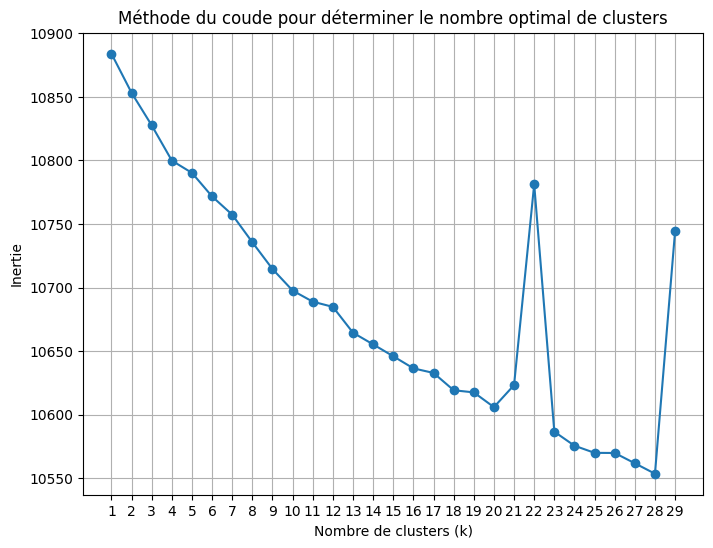

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculer l'inertie pour différentes valeurs de k
inertia = []
k_range = range(1, 30)  # Essayer de 1 à 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters (méthode du coude)
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()



In [ ]:
from sklearn.cluster import KMeans

# On choisit le nombre de clusters (k) = 8

k = 8

# On instancie l'algorithme K-means
# - n_clusters=k : nombre de groupes à construire
# - n_init=10 : on relance l'algo 10 fois avec des points de départ différents,
#               et on garde la meilleure solution (cela évite de tomber sur un mauvais minimum)
# - random_state=42 : pour avoir un résultat reproductible (même partition à chaque exécution)
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

# On applique K-means sur la matrice TF-IDF X et on prédit l'appartenance de chaque document à un cluster
clusters = kmeans.fit_predict(X)

# On affiche les 10 premières affectations de documents (entiers de 0 à k-1)
clusters[:10]

array([3, 1, 1, 1, 6, 6, 1, 0, 1, 7], dtype=int32)


## 4) Réduction de dimension
On projette les vecteurs TF‑IDF en 2D avec **ACP** pour visualiser rapidement.  



In [ ]:
from sklearn.decomposition import PCA

# La matrice X est en format "sparse" (très creuse, beaucoup de zéros).
# Pour appliquer la PCA, on la convertit en tableau dense (array complet).

X_dense = X.toarray()

# On instancie une ACP
# - n_components=2 : on réduit la représentation à 2 dimensions

pca = PCA(n_components=2)

# On applique la PCA sur la matrice dense et on obtient les coordonnées 2D de chaque document
coords_2d = pca.fit_transform(X_dense)


## 5) Visualisation interactive (Plotly)
- Chaque point = un document.  
- Couleurs **discrètes** (palette qualitative) adaptées à des **catégories** (clusters).  
- Le survol affiche un **petit extrait** pour reconnaître le document (confort de lecture).


In [ ]:

import plotly.express as px
import pandas as pd

# On construit un DataFrame avec :
# - x et y : les coordonnées 2D obtenues par la PCA
# - cluster : l'étiquette de cluster trouvée par K-means
# - snippet : un petit extrait de texte (220 caractères max) pour l'affichage au survol
df_plot = pd.DataFrame({
    'x': coords_2d[:,0],
    'y': coords_2d[:,1],
    'cluster': clusters.astype(str),   # conversion en str pour des couleurs discrètes (catégories)
    'snippet': [t[:220].replace('\n',' ') for t in texts]
})

# On crée un nuage de points interactif
# - chaque point = un document
# - la couleur correspond au cluster
# - hover_data permet d’afficher un extrait du texte (snippet) au survol
fig = px.scatter(
    df_plot, x='x', y='y', color='cluster',
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={'snippet': True, 'x': False, 'y': False},
    title='Clustering textes — TF-IDF + K-means + PCA (2D)'
)

# On ajuste l’apparence des points
fig.update_traces(marker=dict(size=6, opacity=0.9))

# On renomme le titre de la légende
fig.update_layout(legend_title_text="Cluster (K-means)",
    xaxis_title="PC1",
    yaxis_title="PC2")

# On affiche la figure
fig.show()


## 6) Explorer les mots dominants par cluster
On lit les **centroïdes** de K‑means (dans l’espace TF‑IDF) pour extraire les mots les plus pondérés.  
Graphique en barres et menu déroulant pour parcourir les clusters.


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Récupère :
# - la liste des termes (vocabulaire TF-IDF)
# - les centroïdes K-means (un vecteur par cluster, dimension = nb de termes)
terms = vectorizer.get_feature_names_out()
centers = kmeans.cluster_centers_
topn = 10  # on affichera les 10 termes les plus pondérés par cluster

bars_data = []
labels_auto = []
for cid in range(k):
    # Indices des top 'topn' termes du cluster cid (tri décroissant des poids du centroïde)
    idx = np.argsort(centers[cid])[::-1][:topn]

    # Mots correspondants et leurs poids TF-IDF dans le centroïde
    words = terms[idx]
    weights = centers[cid][idx]

    # On stocke pour construire les barres et on fabrique un petit label auto (3 mots)
    bars_data.append((words, weights))
    labels_auto.append(" / ".join(words[:3]))

# Base : on initialise la figure avec le cluster 0
base_words, base_weights = bars_data[0]
fig_dd = go.Figure([go.Bar(x=base_words, y=base_weights)])

# Menu déroulant : un bouton par cluster qui remplace les x/y des barres
buttons = []
for cid in range(k):
    w, wt = bars_data[cid]
    buttons.append(dict(
        label=f"Cluster {cid} — {labels_auto[cid]}",  # texte du bouton
        method="update",                               # on met à jour les données existantes
        args=[
            {"x": [w], "y": [wt]},                    # nouvelles valeurs pour les barres
            {"title": f"Top termes — Cluster {cid} ({labels_auto[cid]})"}  # met à jour le titre
        ]
    ))

# Mise en page : titre initial + ajout du menu déroulant
fig_dd.update_layout(
    title=f"Top termes — Cluster 0 ({labels_auto[0]})",
    updatemenus=[dict(type="dropdown", buttons=buttons)]
)

# Ajouter des titres pour les axes
fig_dd.update_layout(xaxis_title="Termes", yaxis_title="Poids dans le centroïde")

# Affiche la figure interactive
fig_dd.show()
